In [1]:
# Thay đổi batch_size, 32 - 64 - 128 - 256 - 512
# Thay đổi layers của lstm, 32 - 64 - 128 - 256

lstm_layers = 64
batch_size = 64

In [2]:
!pip install -q gdown
!gdown 115b2vVHryiPFOPYRumGBDIpx5dT_vH7R
# !gdown 1v_aPFnEk0_3nHy3bDwUlYMAmrQHCX4RY

Downloading...
From: https://drive.google.com/uc?id=115b2vVHryiPFOPYRumGBDIpx5dT_vH7R
To: /kaggle/working/aws_rainfall_all.parquet
100%|██████████████████████████████████████| 50.6M/50.6M [00:01<00:00, 39.6MB/s]


In [3]:
import pandas as pd
from tqdm import tqdm
import gc
import numpy as np

pd.set_option("mode.chained_assignment", None)  # Disable caching
pd.options.display.memory_usage = False  # Reduce memory prints
gc.collect()

df = pd.read_parquet("/kaggle/working/aws_rainfall_all.parquet")

In [4]:
def calculate_optimum_alpha(data):
    X_max = np.max(data)
    X_min = np.min(data)
    X_mean = np.mean(data)
    return ((X_max - X_min) - X_mean) / (X_max - X_min) if (X_max - X_min) != 0 else 0.5

def exponential_smoothing(data, alpha = 0.2):
    smoothed = np.zeros_like(data)
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

corr_matrix = df.corr()

threshold = 0.05  # Set your desired threshold

high_corr_features = corr_matrix["aws_rainfall"][abs(corr_matrix["aws_rainfall"]) > threshold].index.tolist()

high_corr_features = [i for i in high_corr_features if i not in ["Datetime", "Row", "Col"]]

def extract_to_numpy(df, n_steps = 6):
    feature_cols = high_corr_features
    X = []
    y = []
    positions = []
    for (row, col), group in tqdm(df.groupby(["Row", "Col"]), desc="Processing groups", unit="group"):
        group = group.sort_values("Datetime")
        group_values = group[feature_cols].values
        original_rainfall_values = group['aws_rainfall'].values
        alpha = calculate_optimum_alpha(original_rainfall_values)
        # alpha = 0.5
        rainfall_values = exponential_smoothing(original_rainfall_values, alpha)
        for i in range(n_steps, len(group_values)):
            if(len(group_values) < n_steps):
                break
            X.append(group_values[i - n_steps:i])
            y.append(rainfall_values[i])
            positions.append((row, col, group.iloc[i]["Datetime"]))
    return np.array(X), np.array(y), np.array(positions)

In [5]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

columns = [i for i in high_corr_features if i != "aws_rainfall"]
df_feat = df[columns].replace([9999, np.inf, -np.inf], np.nan)

scaler = StandardScaler()
df_feat_scaled = pd.DataFrame(scaler.fit_transform(df_feat), columns = columns)

imputer = KNNImputer(n_neighbors = 5, weights = "distance")
df_feat_imputed_scaled = pd.DataFrame(imputer.fit_transform(df_feat_scaled), columns = columns)

df_feat_imputed = pd.DataFrame(scaler.inverse_transform(df_feat_imputed_scaled), columns = columns)

In [6]:
new_df = pd.concat([df[["Datetime", "Row", "Col", "aws_rainfall"]], df_feat_imputed], axis=1)
del df_feat, df_feat_scaled, df_feat_imputed_scaled, df_feat_imputed

In [7]:
def data_smoothing(df):
    feature_cols = [col for col in df.columns if col not in ["Row", "Col", "Datetime", "aws_rainfall", "smoothed_rainfall"]]
    
    for (row, col), group in tqdm(df.groupby(["Row", "Col"]), desc="Processing groups", unit="group"):
        group = group.sort_values("Datetime")
        original_rainfall_values = group['aws_rainfall'].values
        alpha = calculate_optimum_alpha(original_rainfall_values)
        alpha = 0.5
        rainfall_values = exponential_smoothing(original_rainfall_values, alpha)
        
        # Update smoothed rainfall values back to the DataFrame
        df.loc[group.index, 'smoothed_rainfall'] = rainfall_values
    
    return df

In [8]:
new_df = data_smoothing(new_df)

Processing groups: 100%|██████████| 334/334 [00:03<00:00, 87.86group/s]


In [9]:
x, y, z = extract_to_numpy(new_df)

Processing groups: 100%|██████████| 334/334 [00:57<00:00,  5.77group/s]


In [10]:
print("Shape of X:", x.shape)
print("Shape of y:", y.shape)
print("Shape of positions:", z.shape)

Shape of X: (935534, 6, 13)
Shape of y: (935534,)
Shape of positions: (935534, 3)


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Initialize scalers
rainfall_scaler = MinMaxScaler()  # For past rainfall (first feature) & y
features_scaler = MinMaxScaler()  # For other features

# Fit rainfall scaler on both past rainfall and y
rainfall_scaler.fit(np.concatenate([y.reshape(-1, 1), x[:, :, 0].reshape(-1, 1)]))

# Transform y
y_scaled = rainfall_scaler.transform(y.reshape(-1, 1)).flatten()

# Copy x to avoid modifying original data
x_scaled = np.copy(x)

# Scale only the first feature (past rainfall) using rainfall_scaler
x_scaled[:, :, 0] = rainfall_scaler.transform(x[:, :, 0].reshape(-1, 1)).reshape(x.shape[0], x.shape[1])

# Get the actual number of features dynamically
num_features = x.shape[2] - 1  # Exclude the first feature

# Scale the remaining features
x_scaled[:, :, 1:] = features_scaler.fit_transform(x[:, :, 1:].reshape(-1, num_features)).reshape(x.shape[0], x.shape[1], num_features)

# Function to inverse transform y predictions
def inverse_transform_y(y_pred_scaled):
    return rainfall_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Train-test split
# X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(x_scaled, y_scaled, z, test_size=0.2, random_state=42)

split_index = int(len(x_scaled) * 0.8)  

# Training set (first 80%)
X_train, y_train, z_train = x_scaled[:split_index], y_scaled[:split_index], z[:split_index]

# Testing set (last 20%)
X_test, y_test, z_test = x_scaled[split_index:], y_scaled[split_index:], z[split_index:]

# Reshape z_train and z_test
z_train = z_train.reshape(-1, 3)
z_test = z_test.reshape(-1, 3)

# Ensure y_train and y_test remain 1D
y_train = y_train.flatten()
y_test = y_test.flatten()


In [12]:
n_steps, num_features = x.shape[1], x.shape[2]


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.layers import Attention

def build_model(n_steps, input_dim):
    model = Sequential()
    model.add(LSTM(lstm_layers, activation='relu', return_sequences=True, input_shape=(n_steps, input_dim)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(LSTM(lstm_layers, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(LSTM(lstm_layers, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

model = build_model(n_steps, num_features)
model.summary()

2025-05-02 09:31:55.201623: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746178315.405438      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746178315.455906      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1746178326.337590      18 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(sha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 6, 64)               │          19,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 6, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 6, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 6, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 86,849 (339.25 KB)

 Trainable params: 86,465 (337.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Khai báo Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
history = model.fit(X_train, y_train, epochs=64, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")

Epoch 1/64


I0000 00:00:1746178334.937753      71 service.cc:148] XLA service 0x343e3580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746178334.938190      71 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746178335.723137      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


   48/11695 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - loss: 0.2568 - mae: 0.4463

I0000 00:00:1746178338.464015      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11695/11695 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - loss: 0.0135 - mae: 0.0369 - val_loss: 7.1713e-04 - val_mae: 0.0050
Epoch 2/64
11695/11695 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 1.2390e-04 - mae: 0.0019 - val_loss: 0.0019 - val_mae: 0.0080
Epoch 3/64
11695/11695 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 1.1423e-04 - mae: 0.0020 - val_loss: 0.0023 - val_mae: 0.0075
Epoch 4/64
11695/11695 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 9.4936e-05 - mae: 0.0022 - val_loss: 5.1327e-04 - val_mae: 0.0043
Epoch 5/64
11695/11695 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 9.8282e-05 - mae: 0.0021 - val_loss: 4.9056e-04 - val_mae: 0.0041
Epoch 6/64
11695/11695 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 9.6377e-05 - mae: 0.0019 - val_loss: 4.5315e-04 - val_mae: 0.0039
Epoch 7/64
11695/11695 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 9.0113e-05 - mae: 0.0018 - val_loss: 4.6855e-04 - val_mae: 0.0040
Epoch 8/64
11695/11695 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - loss: 8.8705e-05 - mae: 0.0018 - val_loss: 4.46

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from scipy.stats import pearsonr
import numpy as np

y_pred = model.predict(X_test)
# Flatten predictions and targets
y_true_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

# Filter out zero targets if needed to avoid MAPE division issues
non_zero_indices = y_true_flat != 0
y_true_nz = y_true_flat[non_zero_indices]
y_pred_nz = y_pred_flat[non_zero_indices]

# Metrics
mse = mean_squared_error(y_true_flat, y_pred_flat)
mae = mean_absolute_error(y_true_flat, y_pred_flat)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_flat, y_pred_flat)
pearson_r, _ = pearsonr(y_true_flat, y_pred_flat)

# Print
print(f"MAE:  {mae:.6f}")
print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²:   {r2:.6f}")
print(f"Pearson r: {pearson_r:.6f}")


5848/5848 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
MAE:  0.003720
MSE:  0.000387
RMSE: 0.019670
R²:   0.453020
MAPE: 5421.614838%
Pearson r: 0.677128


In [16]:
from tensorflow.keras.models import load_model
# model = load_model("/kaggle/working/lstm.keras")
model.save("lstm.keras")

5848/5848 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


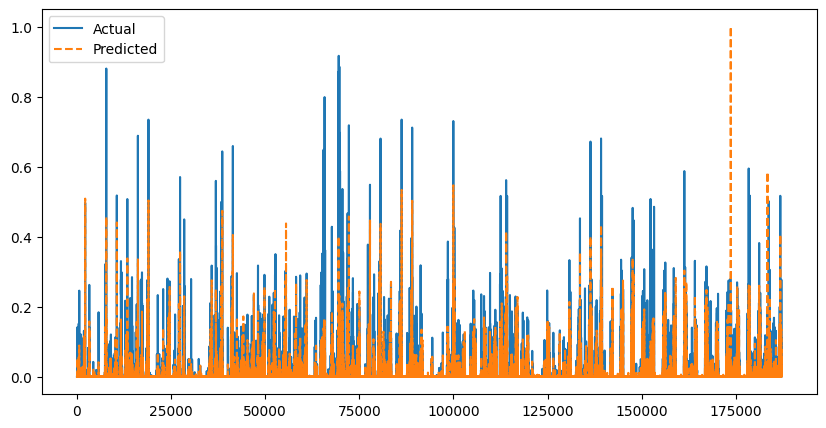

In [17]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted", linestyle="dashed")
plt.legend()
plt.show()
